In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [2]:
data_dir='D:\\programowanie\\python\\deeplearning\\deep_learning\\6\\data'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')

f=open(fname)
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
float_data=np.zeros((len(lines),len(header)-1))

for i ,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values
    


<function matplotlib.pyplot.show(close=None, block=None)>

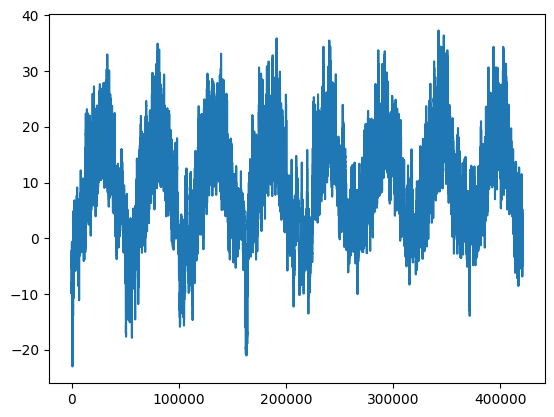

In [4]:
temp=float_data[:,1]#C
plt.plot(range(len(temp)),temp)
plt.show

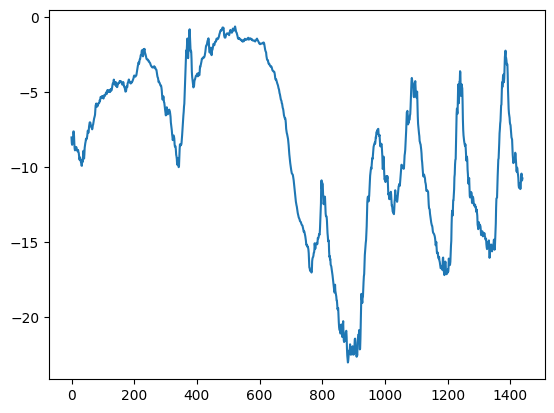

In [5]:
plt.plot(range(1440),temp[:1440])
plt.show()

In [6]:
#normalizacja danych
tht=int(0.2*10**6)
mean=float_data[:tht].mean(axis=0)
float_data-=mean
std=float_data[:tht].std(axis=0)
float_data/=std

In [7]:
#generator w kolejnosci czasowej
def genrator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback

    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else :
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices=range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples,targets

In [8]:
lookback =1440
step =6 
delay=144
bath_size=128
#generatory
train_gen=genrator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=0,
                   max_index=tht,
                   shuffle=True,
                   step=step,
                   batch_size=bath_size)

val_gen=genrator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   shuffle=True,
                   step=step,
                   batch_size=bath_size)

train_gen=genrator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=300001,
                   max_index=None,
                   shuffle=True,
                   step=step,
                   batch_size=bath_size)
val_steps=(300000-200001-lookback)//bath_size
test_steps=(len(float_data)-300001-lookback)//bath_size


In [9]:
def evalute_naive_method():
    bath_meas=[]
    for step in range(val_steps):
        samples, targets=next(val_gen)
        preds=samples[:,-1,1]
        mae=np.mean(np.abs(preds-targets))
        bath_meas.append(mae)
    print(np.mean(bath_meas))
evalute_naive_method()

0.29106581115071206


In [10]:
celsius_mae=0.29*std[1]

In [12]:
model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20


C:\Users\abuka\AppData\Local\Temp\ipykernel_11176\2929364944.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,


500/500 [==============================] - 8s 16ms/step - loss: 2.5944 - val_loss: 0.9967
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 1.2590 - val_loss: 0.5733
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.6324 - val_loss: 0.2992
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3825 - val_loss: 0.3149
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3518 - val_loss: 0.3175
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3537 - val_loss: 0.3183
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3420 - val_loss: 0.3184
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3570 - val_loss: 0.3637
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3477 - val_loss: 0.3181
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3475 - val_loss: 0.3187


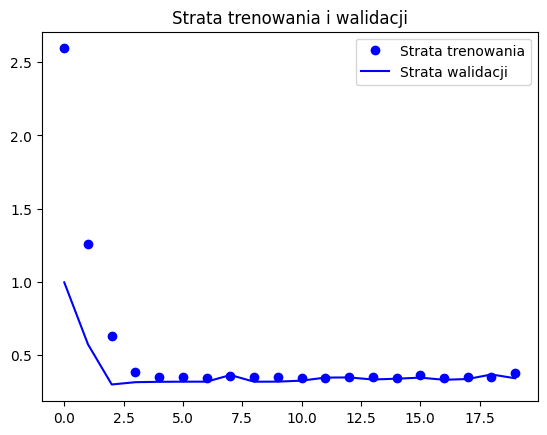

In [13]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss))

plt.figure()
plt.plot(epochs, loss,'bo',label='Strata trenowania')
plt.plot(epochs, val_loss,'b',label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()
plt.show()

In [15]:
#dodanie warstwy GRU
model=Sequential()
model.add(layers.GRU(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20


C:\Users\abuka\AppData\Local\Temp\ipykernel_11176\2361988471.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,


500/500 [==============================] - 49s 96ms/step - loss: 0.2941 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2672 - val_loss: 0.2712
Epoch 3/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2577 - val_loss: 0.2798
Epoch 4/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2473 - val_loss: 0.2843
Epoch 5/20
500/500 [==============================] - 52s 103ms/step - loss: 0.2396 - val_loss: 0.2785
Epoch 6/20
500/500 [==============================] - 52s 104ms/step - loss: 0.2300 - val_loss: 0.2814
Epoch 7/20
500/500 [==============================] - 52s 103ms/step - loss: 0.2213 - val_loss: 0.2862
Epoch 8/20
500/500 [==============================] - 52s 103ms/step - loss: 0.2163 - val_loss: 0.2926
Epoch 9/20
500/500 [==============================] - 52s 104ms/step - loss: 0.2087 - val_loss: 0.2981
Epoch 10/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2030 - 

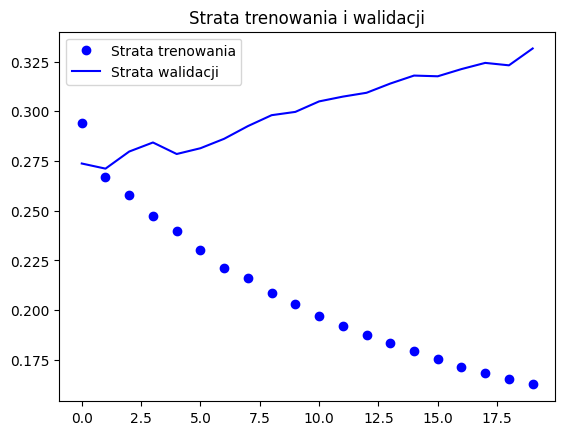

In [16]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss))

plt.figure()
plt.plot(epochs, loss,'bo',label='Strata trenowania')
plt.plot(epochs, val_loss,'b',label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()
plt.show()

In [17]:
#dodanie warstwy GRU i drop
model=Sequential()
model.add(layers.GRU(32,dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/40


C:\Users\abuka\AppData\Local\Temp\ipykernel_11176\2356851557.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,


500/500 [==============================] - 91s 179ms/step - loss: 0.3035 - val_loss: 0.2782
Epoch 2/40
500/500 [==============================] - 88s 176ms/step - loss: 0.2904 - val_loss: 0.2765
Epoch 3/40
500/500 [==============================] - 90s 180ms/step - loss: 0.2822 - val_loss: 0.2786
Epoch 4/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2744 - val_loss: 0.2830
Epoch 5/40
500/500 [==============================] - 91s 183ms/step - loss: 0.2663 - val_loss: 0.2838
Epoch 6/40
500/500 [==============================] - 93s 186ms/step - loss: 0.2616 - val_loss: 0.2838
Epoch 7/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2562 - val_loss: 0.2880
Epoch 8/40
500/500 [==============================] - 89s 177ms/step - loss: 0.2532 - val_loss: 0.2876
Epoch 9/40
500/500 [==============================] - 91s 181ms/step - loss: 0.2501 - val_loss: 0.2926
Epoch 10/40
500/500 [==============================] - 90s 180ms/step - loss: 0.2451

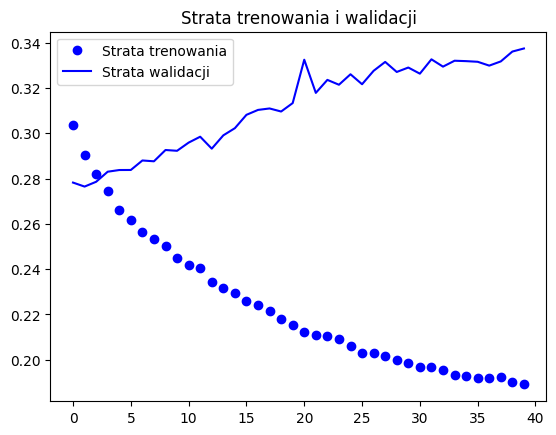

In [18]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss))

plt.figure()
plt.plot(epochs, loss,'bo',label='Strata trenowania')
plt.plot(epochs, val_loss,'b',label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()
plt.show()